In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../Data/Preprocessed_LCData.csv")

In [3]:
#Prepare features and target
X = df.drop(['default_flag', 'grade'], axis=1)  # grade omitted
y = df['default_flag']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1
)


In [6]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, ...], 'n_estimators': [100, 200, ...], 'subsample': [0.8, 1]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [7]:
best_xgb_default = grid.best_estimator_

In [8]:
y_pred = best_xgb_default.predict(X_test)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.98      0.88    291988
           1       0.56      0.10      0.16     82042

    accuracy                           0.78    374030
   macro avg       0.68      0.54      0.52    374030
weighted avg       0.74      0.78      0.72    374030



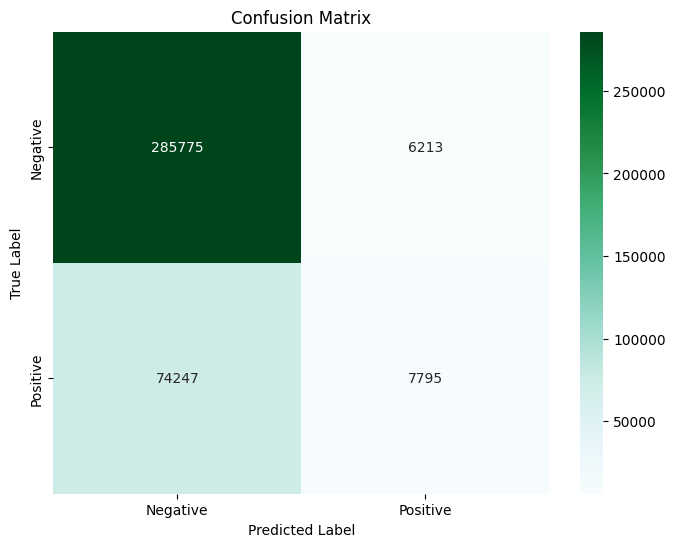

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
import joblib

# Save a model
joblib.dump(best_xgb_default, 'xgb_default_model.pkl')

['xgb_default_model.pkl']